In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import glob
import itertools
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [4]:
sys.path.append("../../..")

In [5]:
from bertrand.model.tokenization import AA_list
from bertrand.negative_decoys.basic_filtering import (
    basic_filtering as basic_filtering_bertrand,
)
from bertrand.negative_decoys.basic_filtering import (
    read_positives_and_group_by_tcr,
    read_reference_tcrs,
)

# Binders

In [6]:
from bertrand.immrep.data_sources import read_test, read_train_be

In [7]:
test = read_test()
train = read_train_be()

# Non-binders

In [8]:
ref = pd.concat([
    pd.read_csv('../../../data/immrep/simulated_cdr3ab_1M_1.csv.gz', index_col=0),
    pd.read_csv('../../../data/immrep/simulated_cdr3ab_1M_2.csv.gz', index_col=0),
])

In [9]:
ref = ref.rename(columns={
    'junction_aa': 'CDR3b', 
    'junction_aa_L': 'CDR3a',
    'v_call': 'TRBV',
    'j_call': 'TRBJ',
    'v_call_L': 'TRAV',
    'j_call_L': 'TRAJ',
})

In [10]:
ref.shape

(2000000, 32)

In [11]:
regex = f"[{''.join(AA_list)}]+"
regex

'[ACDEFGHIKLMNPQRSTVWY]+'

In [12]:
def basic_filtering(ref, train, test):
    return ref[
        (~ref.CDR3a.isin(train.CDR3a_extended)) 
        & (~ref.CDR3a.isin(test.CDR3a_extended)) 
        & (~ref.CDR3b.isin(train.CDR3b_extended)) 
        & (~ref.CDR3b.isin(test.CDR3b_extended)) 
        & (ref.CDR3a.str[0] == "C")
        & (ref.CDR3b.str[0] == "C")
        & ref.CDR3a.str.fullmatch(regex)
        & ref.CDR3b.str.fullmatch(regex)
    ].reset_index(drop=True)



In [13]:
ref = basic_filtering(ref, train, test)
print(ref.shape)

(1955743, 32)


In [14]:
ref = ref.drop_duplicates(subset=['CDR3a', 'CDR3b']).reset_index(drop=True)

In [15]:
ref.shape

(1955723, 32)

In [16]:
peptides = pd.read_csv('../../../data/presented_peptides.csv.gz', index_col=0)

In [17]:
peptides.shape

(211679, 3)

In [18]:
peptides.head(2)

,HLA_type,Peptide2,is_presented
abelin_pos_1,A02:01,KLWEMDNMLI,1
abelin_pos_2,A02:03,KLYDIDVAKV,1


In [19]:
peptides.Peptide2.isin(train.Peptide).value_counts()

False    211622
True         57
Name: Peptide2, dtype: int64

In [20]:
peptides.Peptide2.isin(test.Peptide).value_counts()

False    211673
True          6
Name: Peptide2, dtype: int64

In [21]:
peptides = peptides[~peptides.Peptide2.isin(pd.concat([train.Peptide, test.Peptide]))]

In [22]:
test.HLA.value_counts()

A*02:01    1336
A*01:01     940
B*08:01     458
B*35:01     384
B*07:02     282
A*11:01      84
Name: HLA, dtype: int64

In [23]:
focus_HLA_types = test.HLA.drop_duplicates()

In [24]:
focus_HLA_types = focus_HLA_types.str.replace('*', '', regex=False)

In [25]:
peptides.head(2)

,HLA_type,Peptide2,is_presented
abelin_pos_1,A02:01,KLWEMDNMLI,1
abelin_pos_2,A02:03,KLYDIDVAKV,1


In [26]:
peptides.loc[peptides.HLA_type.isin(focus_HLA_types), 'HLA_type'].value_counts()

A11:01    4108
A02:01    3243
B08:01    3055
B07:02    3054
A01:01    1794
B35:01     927
Name: HLA_type, dtype: int64

In [27]:
peptides_focused = peptides.loc[peptides.HLA_type.isin(focus_HLA_types)]

In [28]:
peptides_focused = peptides_focused.Peptide2.drop_duplicates()

In [29]:
peptides_all = peptides.Peptide2.drop_duplicates()

In [30]:
peptides_all.shape

(141489,)

In [31]:
peptides_focused.shape

(15584,)

In [32]:
peptides_sample = peptides_all.sample(n=len(ref), random_state=42, replace=True)

In [33]:
ref['Peptide'] = peptides_sample.values

In [34]:
SEED = 42

In [35]:
frac=0.04

In [36]:
test_trav = ref.TRAV.drop_duplicates().sample(frac=frac, random_state=SEED)
test_traj = ref.TRAJ.drop_duplicates().sample(frac=frac, random_state=SEED)
test_trbv = ref.TRBV.drop_duplicates().sample(frac=frac, random_state=SEED)
test_trbj = ref.TRBJ.drop_duplicates().sample(frac=frac, random_state=SEED)
test_pep = ref.Peptide.drop_duplicates().sample(frac=frac, random_state=SEED)

In [37]:
test_mask = (
    ref.TRAV.isin(test_trav)
    | ref.TRAJ.isin(test_traj)
    | ref.TRBV.isin(test_trbv)
    | ref.TRBJ.isin(test_trbj)
    | ref.Peptide.isin(test_pep)
)

In [38]:
test_mask.sum()

330996

In [39]:
train_mask = ~test_mask

In [40]:
train_mask.sum()

1624727

In [41]:
train_mask.mean()

0.8307551734064589

In [43]:
train_mlm = ref[train_mask].reset_index(drop=True)
test_mlm = ref[test_mask].reset_index(drop=True)

In [44]:
train_mlm[['Peptide', 'CDR3a', 'CDR3b']].to_csv('../../../data/immrep/ptcr_mlm_train2.csv.gz', index=False)

In [45]:
test_mlm[['Peptide', 'CDR3a', 'CDR3b']].to_csv('../../../data/immrep/ptcr_mlm_val2.csv.gz', index=False)

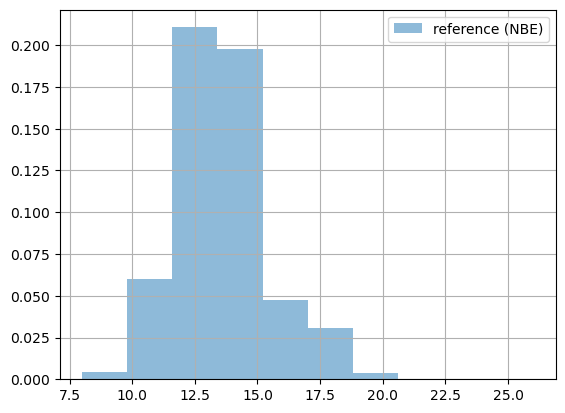

In [41]:
ax = plt.gca()
ref_ab.CDR3a.str.len().hist(ax=ax, density=True, alpha=0.5, label="reference alpha")
ref_tcrs_oakes.str.len().hist(ax=ax, density=True, alpha=0.5, label="reference (Oakes)")
df_pos.CDR3b.str.len().hist(ax=ax, density=True, alpha=0.5, label="binders")
plt.legend()
plt.show()

In [47]:
def downsample_length(dataset, frac=1):
    pos = dataset[dataset.y == 1]
    neg = dataset[dataset.y == 0]

    pos_count = pos.CDR3b.str.len().value_counts().sort_index()
    neg_count = neg.CDR3b.str.len().value_counts().sort_index()

    ratio = pos_count / neg_count
    max_ratio = ratio.max()

    to_remove = round((neg_count * (max_ratio - ratio)) / max_ratio).astype(int)
    to_sample = neg_count - to_remove

    neg_samples = []
    for length, n_to_sample in to_sample.iteritems():
        neg_sample = neg[neg.CDR3b.str.len() == length].sample(int(n_to_sample * frac), random_state=42)
        neg_samples.append(neg_sample)
    dataset_downsampled = pd.concat([pos] + neg_samples)
    return dataset_downsampled

In [52]:
unique_tcrs.shape

(11407093,)

In [56]:
ref_tcrs_dean = basic_filtering_bertrand(unique_tcrs, df_pos)

INFO:root:Basic filtering: started with 11407093 reference TCRs, 11407093 after filtering


In [57]:
ref_tcrs_dean = ref_tcrs_dean.rename(columns={"CDR3b": "junction_aa"}).drop(columns="y")

In [58]:
ref_tcrs_dean.sample(5)

,junction_aa
1915758,CASSLADLGGLEQYF
453050,CASRYGGSSDTQYF
2007832,CASSTAGPPQFWAGTDTQYF
7020283,CASSFVRLEQFF
4305700,CASSEAQGAEETQYF


In [61]:
ref_tcrs_dean.to_csv("../../data/dean_tcr_repertoires/dean_downsampled_11M.csv.gz")

In [62]:
d = pd.read_csv("../../data/presented_peptides.csv.gz", index_col=0)

In [63]:
d.head()

,HLA_type,Peptide2,is_presented
abelin_pos_1,A02:01,KLWEMDNMLI,1
abelin_pos_2,A02:03,KLYDIDVAKV,1
abelin_pos_4,A02:07,QVDDLKAKL,1
abelin_pos_6,A24:02,AYVHMVTHF,1
abelin_pos_10,B35:01,LPDEIYHVY,1


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../data/dean_tcr_repertoires/dean_downsampled_11M.csv.gz")

In [3]:
df.shape

(11407093, 2)

In [4]:
df2 = pd.read_csv("/mnt/storage2/olek/bertrand-rep3/pretraining/mlm_train.csv.gz")

In [5]:
df2.shape

(9125674, 4)

In [6]:
df3 = pd.read_csv("/mnt/storage2/olek/bertrand-rep3/pretraining/mlm_val.csv.gz")

In [7]:
df3.shape

(2281419, 4)